In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/twitter-entity-sentiment-analysis


In [27]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, LSTM, Bidirectional, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [3]:
train_df = pd.read_csv(path + "/twitter_training.csv", header=None)
val_df = pd.read_csv(path + "/twitter_validation.csv", header=None)

In [4]:
train_df.columns =['ID','entity','sentiment','tweet_content']
val_df.columns =['ID','entity','sentiment','tweet_content']

In [5]:
val_df.head()

,ID,entity,sentiment,tweet_content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             74682 non-null  int64 
 1   entity         74682 non-null  object
 2   sentiment      74682 non-null  object
 3   tweet_content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [7]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             1000 non-null   int64 
 1   entity         1000 non-null   object
 2   sentiment      1000 non-null   object
 3   tweet_content  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [8]:
print("Null values in training data: ")
print(train_df.isnull().sum())

Null values in training data: 
ID                 0
entity             0
sentiment          0
tweet_content    686
dtype: int64


In [9]:
train_df = train_df.dropna()

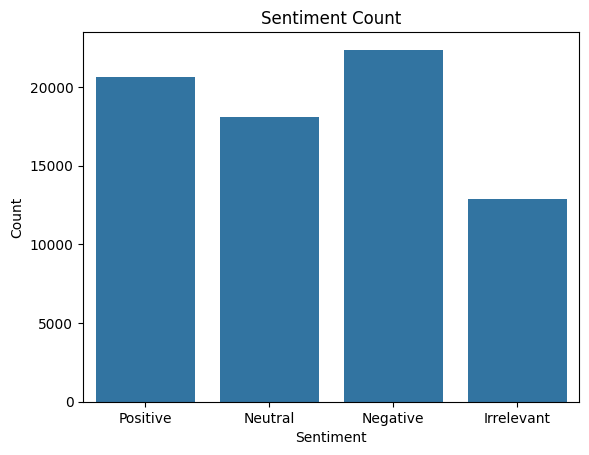

In [10]:
sns.countplot(data = train_df, x = 'sentiment')
plt.title('Sentiment Count')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [11]:
train_df = train_df.drop(columns = ['ID', 'entity'], axis=1)
val_df = val_df.drop(columns = ['ID', 'entity'], axis=1)

In [12]:
train_df.head()

,sentiment,tweet_content
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [13]:
label_encoder = LabelEncoder()
train_df['sentiment_encoded'] = label_encoder.fit_transform(train_df['sentiment'])
val_df['sentiment_encoded'] = label_encoder.transform(val_df['sentiment'])

y_train = to_categorical(train_df['sentiment_encoded'])
y_val = to_categorical(val_df['sentiment_encoded'])

In [14]:
def clean_txt(text):
  text = text.lower()
  text = re.sub(r'http\S+|www\S+|https\S+', '', text)
  text = re.sub(r'\@\w+|\#', '', text)
  text = re.sub(r'[^a-zA-Z\s]', '', text)
  text = re.sub(r'\d+', '', text)
  return text

train_df['clean_content'] = train_df['tweet_content'].apply(clean_txt)
val_df['clean_content'] = val_df['tweet_content'].apply(clean_txt)

In [15]:
train_df.head()

,sentiment,tweet_content,sentiment_encoded,clean_content
0,Positive,im getting on borderlands and i will murder yo...,3,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...,3,i am coming to the borders and i will kill you...
2,Positive,im getting on borderlands and i will kill you ...,3,im getting on borderlands and i will kill you all
3,Positive,im coming on borderlands and i will murder you...,3,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...,3,im getting on borderlands and i will murder y...


In [16]:
train_df = train_df.drop(['sentiment', 'tweet_content'], axis=1)
val_df = val_df.drop(['sentiment', 'tweet_content'], axis=1)

In [17]:
MAX_WORDS = 2000
tokenizer = Tokenizer(num_words=MAX_WORDS, lower = True, oov_token='OOV')
tokenizer.fit_on_texts(train_df['clean_content'])

X_seq = tokenizer.texts_to_sequences(train_df['clean_content'])

MAX_LEN = 100
X_pad = pad_sequences(X_seq, maxlen=MAX_LEN, padding='post', truncating='post')

In [18]:
X_val_seq = tokenizer.texts_to_sequences(val_df['clean_content'])
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')

In [19]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [20]:
!wget http://nlp.stanford.edu/data/glove.6B.zip -P /content/drive/MyDrive/


--2025-08-09 19:07:32--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-08-09 19:07:32--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-08-09 19:07:33--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/content/drive/MyDr

In [21]:
import zipfile

zip_path = '/content/drive/MyDrive/glove.6B.zip'
extract_path = '/content/drive/MyDrive/glove.6B'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Path", extract_path)


Path /content/drive/MyDrive/glove.6B


In [22]:
embedding_index = {}
with open('/content/drive/MyDrive/glove.6B/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = vector

EMBEDDING_DIM = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((MAX_WORDS, EMBEDDING_DIM))

for word, i in word_index.items():
  if i < MAX_WORDS:
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [34]:
vocab_size = len(word_index)+1
embedding_dim = 100

model = Sequential()
model.add(
    Embedding(
        input_dim = MAX_WORDS,
        output_dim = embedding_dim,
        weights = [embedding_matrix],
        input_length = MAX_LEN,
        trainable = True
    )
)
model.add(Bidirectional(LSTM(128)))
model.add(BatchNormalization())

model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))

optimizer = Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │       200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,000 (781.25 KB)

 Trainable params: 200,000 (781.25 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_pad,
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val_pad, y_val),
    callbacks = [early_stopping]
    )


Epoch 1/50
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step - accuracy: 0.4404 - loss: 1.4164 - val_accuracy: 0.6110 - val_loss: 0.9023
Epoch 2/50
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - accuracy: 0.6039 - loss: 0.9612 - val_accuracy: 0.6490 - val_loss: 0.9232
Epoch 3/50
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.6600 - loss: 0.8486 - val_accuracy: 0.7790 - val_loss: 0.5867
Epoch 4/50
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.7116 - loss: 0.7324 - val_accuracy: 0.8360 - val_loss: 0.4615
Epoch 5/50
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.7637 - loss: 0.6122 - val_accuracy: 0.8750 - val_loss: 0.3752
Epoch 6/50
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.8066 - loss: 0.5063 - val_accuracy: 0.8940 - val_loss: 0.3180
Epoch 7/50
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.8403 - loss: 0.4259 - val_accuracy: 0.9280 - val_loss: 0.2192
Epoch 8/50
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - accuracy: 0.8652 -

In [37]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

print(f"Final Training Accuracy: {train_accuracy[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")
print(f"Final Training Loss: {train_loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")

Final Training Accuracy: 0.9419
Final Validation Accuracy: 0.9470
Final Training Loss: 0.1481
Final Validation Loss: 0.2429


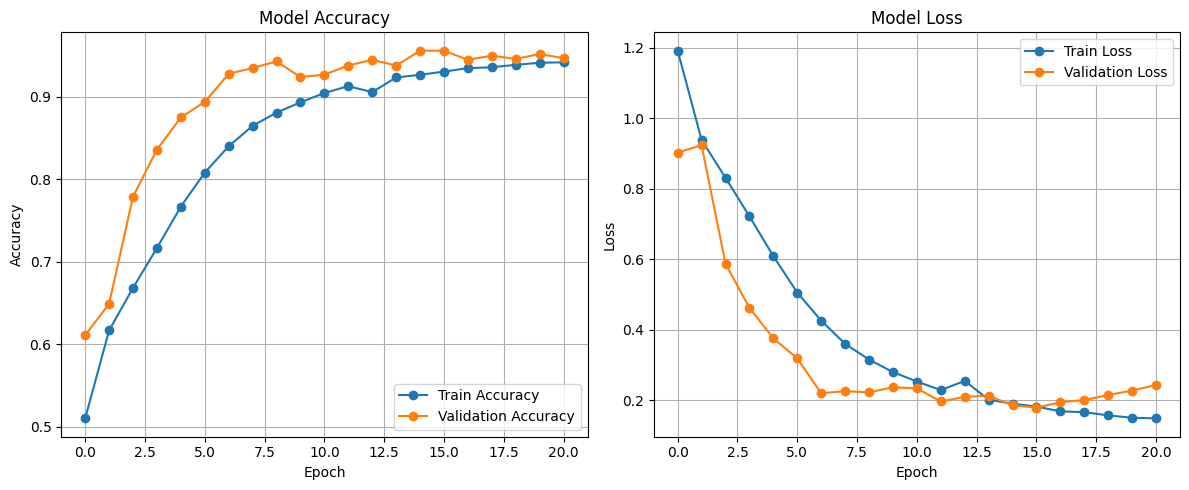

In [38]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [40]:
model.save('/content/drive/MyDrive/sentiment_analysis_model_lstm.h5')